# LANDARTs - Landsat automatic retrieval of surface temperatures

LANDARTs is a Python tool that works (currently) only with Landsat archives in the new metadata file format (data acquired after 2012) that can be downloaded from the [USGS website](https://earthexplorer.usgs.gov/).

Check this paper for more information : [A Software Tool for Atmospheric Correction and Surface Temperature Estimation of Landsat Infrared Thermal Data](https://www.mdpi.com/2072-4292/8/9/696)


In [2]:
import glob, subprocess, os
import rasterio
import rasterio.plot
import rasterio.mask
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

**Set directory**

In [17]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_nb        = '13'

# Directory for all work files
work_path = f'{computer_path}STUDENTS/GROUP_{grp_nb}/TP/'

# Input directory
roi_path     = f'{work_path}ROI/'
landsat_path = f'{work_path}LANDSAT/'

# Output directory
lst_path = f'{work_path}LST/'

Path(lst_path).mkdir(parents=True, exist_ok=True)

**Set region of interest**

In [ ]:
crs = 'EPSG:32631'

roi_name     = 'extent_roi'
roi_filename = f'{roi_name}_{crs[5:]}.shp'
roi_file     = f'{roi_path}{roi_filename}'

roi_gdf = gpd.read_file(roi_file)

print(f'ROI shapefile : {roi_file}')

**Set parameters**

In [5]:
nodata_val = -9999

## 1. Get Land Surface Temperature (LST) using LANDARTs

**To be launch on the lab'servers by the assistant - LANDARTs tool can not be installed in computer room !**

Download the Landsat products in `".tar.gz"` format and store them in the `landsat_path` folder. Then ask to the assistant to run the following block of code (step 1) and tell him the exact location of your data.

For example, the Landsat products for which you want to get the Land Surface Temperature (LST) are located in : *X:/STUDENTS/GROUP_99/TP/LANDSAT/*


gzip -c LC08_L1TP_198025_20200731_20200908_02_T1.tar > LC08_L1TP_198025_20200731_20200908_02_T1.tar.gz

In [19]:
for input_file in glob.glob(f'{landsat_path}*.tar.gz'):
    
    directory = input_file[:-7]

    output_file = f'{lst_path}{os.path.basename(input_file)[:-7]}_LST.tif'

    if not os.path.isfile(output_file):
        
        cmd = 'bash launch_landarts.sh'
        cmd += f' {input_file}'
        cmd += f' {output_file}'
        cmd += f' {directory}'

        subprocess.call(cmd, shell=True)

        print(os.path.basename(input_file))
        print('is converted to')
        print(os.path.basename(output_file))
    else:

        print(f'LST file {output_file} already exist !')

LST file /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_13/TP/LST/LC08_L1TP_198025_20180216_20200902_02_T1_LST.tif already exist !
LST file /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_13/TP/LST/LC08_L1TP_198025_20180507_20200901_02_T1_LST.tif already exist !
LANDARTs starts ...
LANDARTs finished !
LC08_L1TP_198025_20180726_20200831_02_T1.tar.gz
is converted to
LC08_L1TP_198025_20180726_20200831_02_T1_LST.tif
LANDARTs starts ...
LANDARTs finished !
LC08_L1TP_199025_20180701_20200831_02_T1.tar.gz
is converted to
LC08_L1TP_199025_20180701_20200831_02_T1_LST.tif
LANDARTs starts ...
LANDARTs finished !
LC08_L1TP_198025_20181014_20200830_02_T1.tar.gz
is converted to
LC08_L1TP_198025_20181014_20200830_02_T1_LST.tif
LANDARTs starts ...
LANDARTs finished !
LC08_L1TP_199024_20180701_20200831_02_T1.tar.gz
is converted to
LC08_L1TP_199024_20180701_20200831_02_T1_LST.tif
LANDARTs starts ...
LANDARTs finished !
LC08_L1TP_199024_20180717_20200831_02_T1.tar.gz
is converted to
LC08_L1TP_199024_201

## 2. Preprocess LST images

2.1 Mask invalid pixels

2.2 Convert Kelvin to Celsius degree

In [13]:
list_im_to_process = glob.glob(f'{lst_path}*_LST.tif')

print(f'There are {len(list_im_to_process)} images to preprocess')

for im_file in list_im_to_process:

    im_file_prepro = f'{lst_path}{os.path.basename(im_file)[:-4]}_Celsius_BQA.tif'
    
    if not os.path.isfile(im_file_prepro):

        # Get date of image
        date = os.path.basename(im_file)[17:17+8]
        print(f'Date : {date}')

        # Find QA band corresponding to the given Landsat image
        bqa_file = glob.glob(f'{landsat_path}{os.path.basename(im_file)[:-8]}/*_BQA.TIF')[0]
        
        print(im_file)
        print(bqa_file)
        
        # Open LST file
        src_im = rasterio.open(im_file, "r")
        im = src_im.read(1)

        # Open Quality Assessment band 
        src_bqa = rasterio.open(bqa_file, "r")
        BQA = src_bqa.read(1)

        ###########################
        ### Mask invalid pixels ###
        ###########################

        # Change invalid pixels categories by NaN
        BQA = BQA.astype(float)
        BQA = np.where(BQA == 2720, 1, np.nan)

        # Mask LST with BQA
        im_bqa = im * BQA
        
        #########################################
        ### Convert Kelvin to degrees Celsius ###
        #########################################
        
        im_bqa_celsius = im_bqa / 100 - 273.15

        # Chnage Numpy nan by no data value
        im_bqa_celsius[np.isnan(im_bqa_celsius)] = nodata_val

        # Update metadata
        meta = src_im.meta.copy()

        meta.update(nodata=nodata_val,
                    dtype= "float32")
                
        # Write output image
        dst = rasterio.open(im_file_prepro, "w", **meta)
        dst.write(im_bqa_celsius,1)

        # Close rasterio objects
        src_im.close()
        src_bqa.close()
        dst.close()


        print(f'A new raster file is created : {im_file_prepro}')

print('--> All images are masked and converted to Celsius degrees !')

There are 1 images to preprocess
Date : 20180216


IndexError: list index out of range

## 3. Clip images to the extent of Region of Interest

In [7]:
list_im_to_clip = glob.glob(f'{lst_path}*_Celsius_BQA.tif')

print(f'There are {len(list_im_to_clip)} images to clip')

There are 2 images to clip


**Check if the ROI is located in one of the image to clip**

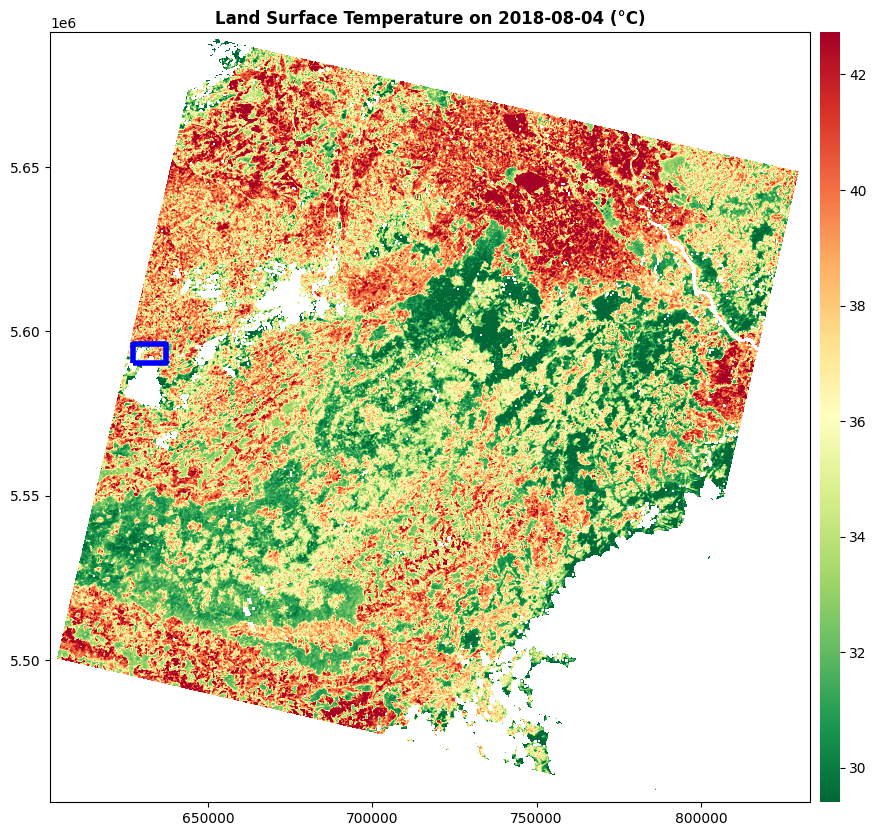

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot first image of the list
im_file = list_im_to_clip[0]

date_str = os.path.basename(im_file)[17:17+8]
date = datetime.strptime(date_str, "%Y%m%d").date()

src = rasterio.open(im_file, "r")
im = src.read(1)

color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 5)
p95 = np.nanpercentile(im, 95)

im_rio = rasterio.plot.show(src,
                            cmap=reversed_color_map,
                            vmin=p5,
                            vmax=p95,
                            title=f"Land Surface Temperature on {date} (°C)",
                            ax=ax)

im_rio = im_rio.get_images()[0]

# Plot ROI vector
roi_gdf.plot(facecolor='none', edgecolor='blue', linewidth = 4, ax=ax)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.box(False)

In [9]:
for im_file in list_im_to_clip:

    im_file_clipped = f'{lst_path}{os.path.basename(im_file)[:-4]}_ROI.tif'
    
    if not os.path.isfile(im_file_clipped):
        
        # Open file
        src = rasterio.open(im_file, "r")

        im_clipped, out_transform = rasterio.mask.mask(src,
                                                      roi_gdf.geometry,
                                                      all_touched=True,
                                                      crop=True)

        # Update metadata
        meta = src_im.meta.copy()

        meta.update(width = im_clipped.shape[2],
                    height = im_clipped.shape[1],
                    transform = out_transform,
                    nodata=nodata_val,
                    dtype= "float32")
        
        print(meta)
        
        # Write clipped image
        dst = rasterio.open(im_file_clipped, "w", **meta)
        dst.write(im_clipped)

        # Close rasterio objects
        src.close()
        dst.close()


        print(f'A new raster file is created : {im_file_clipped}')

print('--> All images are clipped !')

--> All images are clipped !


**Plot last clipped image**

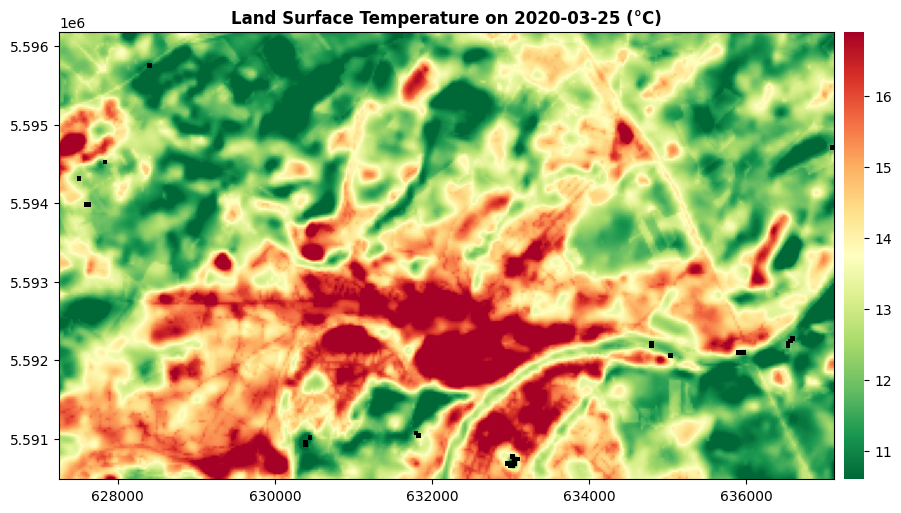

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

im_file = im_file_clipped

date_str = os.path.basename(im_file)[17:17+8]
date = datetime.strptime(date_str, "%Y%m%d").date()

src = rasterio.open(im_file, "r")
im = src.read(1)

color_map = plt.cm.get_cmap("RdYlGn")
color_map.set_bad(color='black')
reversed_color_map = color_map.reversed()

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 5)
p95 = np.nanpercentile(im, 95)

im_rio = rasterio.plot.show(src,
                            cmap=reversed_color_map,
                            vmin=p5,
                            vmax=p95,
                            ax=ax,
                            title=f"Land Surface Temperature on {date} (°C)")
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.box(False)